In [1]:
import pathlib
import warnings
from typing import List, Tuple

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.multioutput import MultiOutputRegressor

In [2]:
def shuffle_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Shuffle the data in the DataFrame.
    """
    df_shuffled = df.copy()
    for col in df_shuffled.columns:
        # permute the columns
        df_shuffled[col] = np.random.permutation(df_shuffled[col])
    return df_shuffled

In [3]:
# read in the data
sc_train_final_time_point_file_path = pathlib.Path(
    "../results/train_sc_profile.parquet"
).resolve()
sc_test_final_time_point_file_path = pathlib.Path(
    "../results/test_sc_profile.parquet"
).resolve()

sc_train_endpoint_file_path = pathlib.Path(
    "../results/train_sc_profile_terminal_time.parquet"
).resolve()
sc_test_endpoint_file_path = pathlib.Path(
    "../results/test_sc_profile_terminal_time.parquet"
).resolve()

sc_train_X_df = pd.read_parquet(sc_train_final_time_point_file_path)
sc_test_X_df = pd.read_parquet(sc_test_final_time_point_file_path)
sc_train_y_df = pd.read_parquet(sc_train_endpoint_file_path)
sc_test_y_df = pd.read_parquet(sc_test_endpoint_file_path)

print(f"Training data shape: {sc_train_X_df.shape}, {sc_train_y_df.shape}")
print(f"Testing data shape: {sc_test_X_df.shape}, {sc_test_y_df.shape}")
sc_train_X_df = sc_train_X_df.loc[
    sc_train_X_df["Metadata_Time"] == sc_train_X_df["Metadata_Time"].max()
]
sc_test_X_df = sc_test_X_df.loc[
    sc_test_X_df["Metadata_Time"] == sc_test_X_df["Metadata_Time"].max()
]
print(f"Training data shape: {sc_train_X_df.shape}, {sc_train_y_df.shape}")
print(f"Testing data shape: {sc_test_X_df.shape}, {sc_test_y_df.shape}")

model_dir = pathlib.Path("../models").resolve()
model_dir.mkdir(parents=True, exist_ok=True)
results_dir = pathlib.Path("../results").resolve()
results_dir.mkdir(parents=True, exist_ok=True)

Training data shape: (23720, 2379), (2300, 541)
Testing data shape: (49544, 2379), (4910, 541)
Training data shape: (2300, 2379), (2300, 541)
Testing data shape: (4910, 2379), (4910, 541)


In [4]:
# load models
elastic_net_all_annexinv_features_model_path = pathlib.Path(
    "../models/train_elastic_net_all_annexinv_features_model.joblib"
).resolve(strict=True)
elastic_net_all_annexinv_features_model_shuffled_path = pathlib.Path(
    "../models/train_shuffled_elastic_net_all_annexinv_features_model_shuffled.joblib"
).resolve(strict=True)
elastic_net_single_terminal_features_model_path = pathlib.Path(
    "../models/train_elastic_net_single_terminal_features_model.joblib"
).resolve(strict=True)
elastic_net_single_terminal_features_model_shuffled_path = pathlib.Path(
    "../models/train_shuffled_elastic_net_single_terminal_features_model_shuffled.joblib"
).resolve(strict=True)


elastic_net_all_annexinv_features_model = joblib.load(
    elastic_net_all_annexinv_features_model_path
)
elastic_net_all_annexinv_features_model_shuffled = joblib.load(
    elastic_net_all_annexinv_features_model_shuffled_path
)
elastic_net_single_terminal_features_model = joblib.load(
    elastic_net_single_terminal_features_model_path
)
elastic_net_single_terminal_features_model_shuffled = joblib.load(
    elastic_net_single_terminal_features_model_shuffled_path
)

In [5]:
print(
    f"training_df_X shape: {sc_train_X_df.shape}",
    sc_train_X_df["Metadata_sc_unique_track_id"].nunique(),
)
print(
    f"training_df_y shape: {sc_train_y_df.shape}",
    sc_train_y_df["Metadata_sc_unique_track_id"].nunique(),
)
print(
    f"test_df_X shape: {sc_test_X_df.shape}",
    sc_test_X_df["Metadata_sc_unique_track_id"].nunique(),
)
print(
    f"test_df_y shape: {sc_test_y_df.shape}",
    sc_test_y_df["Metadata_sc_unique_track_id"].nunique(),
)
assert (
    sc_train_X_df["Metadata_sc_unique_track_id"].nunique()
    == sc_train_y_df["Metadata_sc_unique_track_id"].nunique()
)
assert (
    sc_train_X_df["Metadata_sc_unique_track_id"].nunique()
    == sc_train_y_df["Metadata_sc_unique_track_id"].nunique()
)
sc_train_X_df_shuffled = sc_train_X_df.copy()
sc_train_X_df_shuffled = shuffle_data(sc_train_X_df_shuffled)
sc_test_X_df_shuffled = sc_test_X_df.copy()
sc_test_X_df_shuffled = shuffle_data(sc_test_X_df_shuffled)

training_df_X shape: (2300, 2379) 2300
training_df_y shape: (2300, 541) 2300
test_df_X shape: (4910, 2379) 4910
test_df_y shape: (4910, 541) 4910


In [6]:
train_x_metadata = [x for x in sc_train_X_df.columns if "Metadata" in x]
train_y_metadata = [y for y in sc_train_y_df.columns if "Metadata" in y]
train_X_features = [x for x in sc_train_X_df.columns if x not in train_x_metadata]
train_y_features = [y for y in sc_train_y_df.columns if y not in train_y_metadata]

train_x_shuffled_metadata = [
    x for x in sc_train_X_df_shuffled.columns if "Metadata" in x
]
train_y_shuffled_metadata = [y for y in sc_train_y_df.columns if "Metadata" in y]
train_x_shuffled_features = [
    x for x in sc_train_X_df_shuffled.columns if x not in train_x_shuffled_metadata
]

train_df_x_metadata = sc_train_X_df[train_x_metadata]
train_df_y_metadata = sc_train_y_df[train_y_metadata]
train_df_x_features = sc_train_X_df[train_X_features]
train_df_y_features = sc_train_y_df[train_y_features]
train_df_x_shuffled_metadata = sc_train_X_df_shuffled[train_x_shuffled_metadata]
train_df_x_shuffled_features = sc_train_X_df_shuffled[train_x_shuffled_features]

In [7]:
test_x_metadata = [x for x in sc_test_X_df.columns if "Metadata" in x]
test_y_metadata = [y for y in sc_test_y_df.columns if "Metadata" in y]
testing_X_features = [x for x in sc_test_X_df.columns if x not in test_x_metadata]
testing_y_features = [y for y in sc_test_y_df.columns if y not in test_y_metadata]

test_x_shuffled_metadata = [x for x in sc_test_X_df_shuffled.columns if "Metadata" in x]
test_y_shuffled_metadata = [y for y in sc_test_y_df.columns if "Metadata" in y]
test_x_shuffled_features = [
    x for x in sc_test_X_df_shuffled.columns if x not in test_x_shuffled_metadata
]

test_df_x_metadata = sc_test_X_df[test_x_metadata]
test_df_y_metadata = sc_test_y_df[test_y_metadata]
test_df_x_features = sc_test_X_df[testing_X_features]
test_df_y_features = sc_test_y_df[testing_y_features]
test_df_x_shuffled_metadata = sc_test_X_df_shuffled[test_x_shuffled_metadata]
test_df_x_shuffled_features = sc_test_X_df_shuffled[test_x_shuffled_features]

In [8]:
annexin_feature = "Cytoplasm_Intensity_IntegratedIntensity_AnnexinV"

In [9]:
dict_of_train_tests = {
    "single_feature": {
        "train": {
            "X": train_df_x_features.to_numpy(),
            "y": train_df_y_features[annexin_feature].to_numpy(),
            "x_metadata": train_df_x_metadata,
            "y_metadata": train_df_y_metadata,
            "model": elastic_net_single_terminal_features_model,
            "model_name": "elastic_net_single_terminal_features_model",
            "y_column_names": [annexin_feature],
        },
        "train_shuffled": {
            "X": train_df_x_shuffled_features.to_numpy(),
            "y": train_df_y_features[annexin_feature].to_numpy(),
            "x_metadata": train_df_x_shuffled_metadata,
            "y_metadata": train_df_y_metadata,
            "model": elastic_net_single_terminal_features_model_shuffled,
            "model_name": "elastic_net_single_terminal_features_model_shuffled",
            "y_column_names": [annexin_feature],
        },
        "test": {
            "X": test_df_x_features.to_numpy(),
            "y": test_df_y_features[annexin_feature].to_numpy(),
            "x_metadata": test_df_x_metadata,
            "y_metadata": test_df_y_metadata,
            "model": elastic_net_single_terminal_features_model,
            "model_name": "elastic_net_single_terminal_features_model",
            "y_column_names": [annexin_feature],
        },
        "test_shuffled": {
            "X": test_df_x_shuffled_features.to_numpy(),
            "y": test_df_y_features[annexin_feature].to_numpy(),
            "x_metadata": test_df_x_shuffled_metadata,
            "y_metadata": test_df_y_metadata,
            "model": elastic_net_single_terminal_features_model_shuffled,
            "model_name": "elastic_net_single_terminal_features_model_shuffled",
            "y_column_names": [annexin_feature],
        },
    },
    "annexinV_features": {
        "train": {
            "X": train_df_x_features.to_numpy(),
            "y": train_df_y_features.to_numpy(),
            "x_metadata": train_df_x_metadata,
            "y_metadata": train_df_y_metadata,
            "model": elastic_net_all_annexinv_features_model,
            "model_name": "elastic_net_all_annexinv_features_model",
            "y_column_names": train_df_y_features.columns.tolist(),
        },
        "train_shuffled": {
            "X": train_df_x_shuffled_features.to_numpy(),
            "y": train_df_y_features.to_numpy(),
            "x_metadata": train_df_x_shuffled_metadata,
            "y_metadata": train_df_y_metadata,
            "model": elastic_net_all_annexinv_features_model_shuffled,
            "model_name": "elastic_net_all_annexinv_features_model_shuffled",
            "y_column_names": train_df_y_features.columns.tolist(),
        },
        "test": {
            "X": test_df_x_features.to_numpy(),
            "y": test_df_y_features.to_numpy(),
            "x_metadata": test_df_x_metadata,
            "y_metadata": test_df_y_metadata,
            "model": elastic_net_all_annexinv_features_model,
            "model_name": "elastic_net_all_annexinv_features_model",
            "y_column_names": test_df_y_features.columns.tolist(),
        },
        "test_shuffled": {
            "X": test_df_x_shuffled_features.to_numpy(),
            "y": test_df_y_features.to_numpy(),
            "x_metadata": test_df_x_shuffled_metadata,
            "y_metadata": test_df_y_metadata,
            "model": elastic_net_all_annexinv_features_model_shuffled,
            "model_name": "elastic_net_all_annexinv_features_model_shuffled",
            "y_column_names": test_df_y_features.columns.tolist(),
        },
    },
}

In [10]:
prediction_df_list = []
stats_df_list = []
# test the model
for model_type in dict_of_train_tests.keys():
    for train_test_key, train_test_data in tqdm.tqdm(
        dict_of_train_tests[model_type].items()
    ):
        print(f"Testing model for {train_test_key}...{model_type}")
        X = train_test_data["X"]
        y = train_test_data["y"]
        x_metadata = dict_of_train_tests[model_type][train_test_key]["x_metadata"]
        y_metadata = dict_of_train_tests[model_type][train_test_key]["y_metadata"]
        # find the number of NaNs
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            y_pred = dict_of_train_tests[model_type][train_test_key]["model"].predict(X)
        r2 = r2_score(y, y_pred)
        evs = explained_variance_score(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        if "shuffle" in train_test_key:
            shuffle = "Shuffled baseline"
        else:
            shuffle = "Model"
        print(
            f"R2: {r2:.4f}, Explained Variance Score: {evs:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}"
        )
        predictions_df = pd.DataFrame(
            y_pred,
            columns=dict_of_train_tests[model_type][train_test_key]["y_column_names"],
        )
        predictions_df.insert(0, "Model_type", model_type)
        predictions_df.insert(1, "Train_test_key", train_test_key)
        predictions_df.insert(2, "Model_name", train_test_data["model_name"])
        predictions_df.insert(3, "dose", x_metadata["Metadata_dose"].values)
        predictions_df.insert(4, "time", x_metadata["Metadata_Time"].values)
        predictions_df.insert(
            5, "sc_unique_track_id", x_metadata["Metadata_sc_unique_track_id"].values
        )
        predictions_df.insert(6, "shuffle", shuffle)
        stats_df = pd.DataFrame(
            {
                "model_type": [model_type],
                "train_test_key": [train_test_key],
                "model_name": [train_test_data["model_name"]],
                "r2": [r2],
                "explained_variance_score": [evs],
                "mae": [mae],
                "mse": [mse],
                "rmse": [rmse],
            }
        )
        stats_df.insert(0, "shuffle", shuffle)
        prediction_df_list.append(predictions_df)
        stats_df_list.append(stats_df)

  0%|          | 0/4 [00:00<?, ?it/s]/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
100%|██████████| 4/4 [00:00<00:00, 

Testing model for train...single_feature
R2: 0.0682, Explained Variance Score: 0.0682, MAE: 0.6688, MSE: 0.8018, RMSE: 0.8955
Testing model for train_shuffled...single_feature
R2: 0.0004, Explained Variance Score: 0.0004, MAE: 0.6990, MSE: 0.8602, RMSE: 0.9275
Testing model for test...single_feature
R2: 0.0106, Explained Variance Score: 0.0109, MAE: 0.7234, MSE: 0.9809, RMSE: 0.9904
Testing model for test_shuffled...single_feature
R2: -0.0078, Explained Variance Score: -0.0012, MAE: 0.7219, MSE: 0.9991, RMSE: 0.9996


  0%|          | 0/4 [00:00<?, ?it/s]/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/time

Testing model for train...annexinV_features


/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/si

R2: 0.0583, Explained Variance Score: 0.0583, MAE: 0.7772, MSE: 1.2209, RMSE: 1.1049
Testing model for train_shuffled...annexinV_features


/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/si

R2: -0.0002, Explained Variance Score: -0.0002, MAE: 0.8197, MSE: 1.3660, RMSE: 1.1688
Testing model for test...annexinV_features


/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/si

R2: 0.0241, Explained Variance Score: 0.0257, MAE: 0.7507, MSE: 1.0901, RMSE: 1.0441
Testing model for test_shuffled...annexinV_features


/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(
/home/lippincm/miniforge3/envs/timelapse_analaysis_env/lib/python3.11/si

R2: -0.0139, Explained Variance Score: -0.0003, MAE: 0.7874, MSE: 1.1562, RMSE: 1.0753


In [11]:
predictions_df = pd.concat(prediction_df_list, axis=0).reset_index(drop=True)
stats_df = pd.concat(stats_df_list, axis=0).reset_index(drop=True)
predictions_df.head()

,Model_type,Train_test_key,Model_name,dose,time,sc_unique_track_id,shuffle,Cytoplasm_Intensity_IntegratedIntensity_AnnexinV,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_Compactness,...,Nuclei_Texture_Correlation_AnnexinV_3_00_256,Nuclei_Texture_Correlation_AnnexinV_3_01_256,Nuclei_Texture_Correlation_AnnexinV_3_02_256,Nuclei_Texture_Correlation_AnnexinV_3_03_256,Nuclei_Texture_Correlation_DNA_3_02_256,Nuclei_Texture_DifferenceVariance_AnnexinV_3_01_256,Nuclei_Texture_InverseDifferenceMoment_AnnexinV_3_03_256,Nuclei_Texture_InverseDifferenceMoment_DNA_3_03_256,Nuclei_Texture_SumAverage_AnnexinV_3_00_256,Nuclei_Texture_SumAverage_DNA_3_01_256
0,single_feature,train,elastic_net_single_terminal_features_model,39.06,12,C-09_0002_15,Model,0.055603,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,single_feature,train,elastic_net_single_terminal_features_model,39.06,12,C-09_0002_9,Model,-0.095295,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,single_feature,train,elastic_net_single_terminal_features_model,39.06,12,C-09_0002_26,Model,-0.274239,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,single_feature,train,elastic_net_single_terminal_features_model,39.06,12,C-09_0002_167,Model,-0.032533,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,single_feature,train,elastic_net_single_terminal_features_model,39.06,12,C-09_0002_170,Model,-0.195843,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# save the predictions
predictions_file_path = results_dir / "model_test_predictions.parquet"
predictions_df.to_parquet(predictions_file_path, index=False)
stats_file_path = results_dir / "model_test_stats.parquet"
stats_df.to_parquet(stats_file_path, index=False)

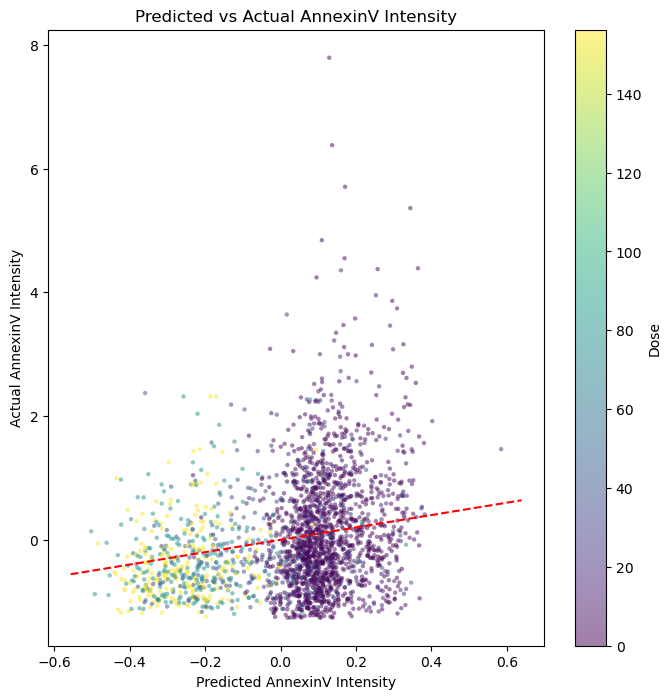

In [13]:
# plot the predictions vs actual for annexin_feature
plt.figure(figsize=(8, 8))

# Get the dose values for coloring
dose_values = dict_of_train_tests["single_feature"]["train"]["x_metadata"][
    "Metadata_dose"
].values
# Convert dose values to numeric to ensure proper colormap handling
dose_values = pd.to_numeric(dose_values, errors="coerce")

scatter = plt.scatter(
    predictions_df[
        (predictions_df["Train_test_key"] == "train")
        & (predictions_df["Model_type"] == "single_feature")
    ][annexin_feature],
    dict_of_train_tests["single_feature"]["train"]["y"],
    alpha=0.5,
    s=10,
    c=dose_values,
    cmap="viridis",
    edgecolors="none",
)

# Add colorbar to show dose mapping
plt.colorbar(scatter, label="Dose")

# Get current axis limits
xlims = plt.xlim()
ylims = plt.ylim()

# Use the overlapping range for the y=x line
min_val = max(xlims[0], ylims[0])
max_val = min(xlims[1], ylims[1])

# Plot y=x line in data coordinates
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="red",
    linestyle="--",
    label="Perfect prediction (y=x)",
)
plt.xlabel("Predicted AnnexinV Intensity")
plt.ylabel("Actual AnnexinV Intensity")
plt.title("Predicted vs Actual AnnexinV Intensity")
plt.show()

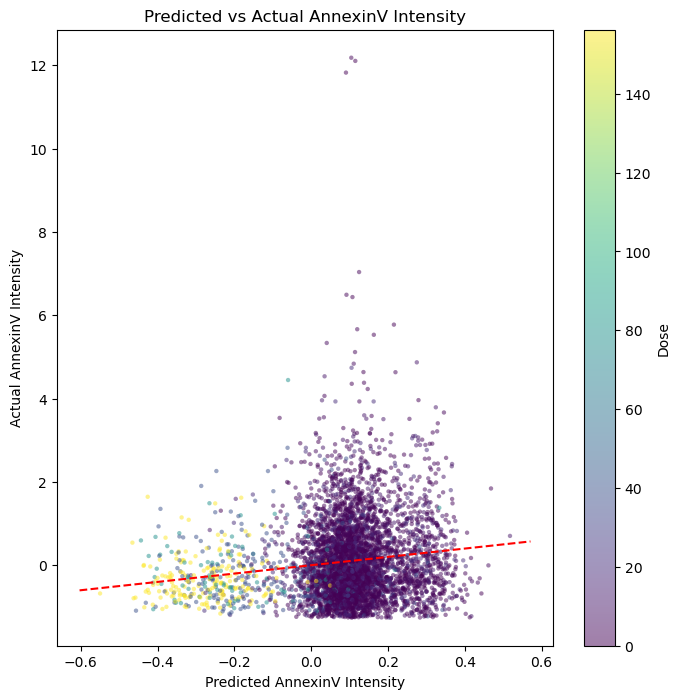

In [14]:
# plot the predictions vs actual for annexin_feature
plt.figure(figsize=(8, 8))

# Get the dose values for coloring
dose_values = dict_of_train_tests["single_feature"]["test"]["x_metadata"][
    "Metadata_dose"
].values
# Convert dose values to numeric to ensure proper colormap handling
dose_values = pd.to_numeric(dose_values, errors="coerce")

scatter = plt.scatter(
    predictions_df[
        (predictions_df["Train_test_key"] == "test")
        & (predictions_df["Model_type"] == "single_feature")
    ][annexin_feature],
    dict_of_train_tests["single_feature"]["test"]["y"],
    alpha=0.5,
    s=10,
    c=dose_values,
    cmap="viridis",
    edgecolors="none",
)

# Add colorbar to show dose mapping
plt.colorbar(scatter, label="Dose")

# Get current axis limits
xlims = plt.xlim()
ylims = plt.ylim()

# Use the overlapping range for the y=x line
min_val = max(xlims[0], ylims[0])
max_val = min(xlims[1], ylims[1])

# Plot y=x line in data coordinates
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="red",
    linestyle="--",
    label="Perfect prediction (y=x)",
)
plt.xlabel("Predicted AnnexinV Intensity")
plt.ylabel("Actual AnnexinV Intensity")
plt.title("Predicted vs Actual AnnexinV Intensity")
plt.show()